In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
from sklearn.metrics import precision_recall_curve, roc_curve
import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets, LabelConverter
from MedSAM_HCP.utils_hcp import show_mask, show_box

In [2]:
def read_format_table(path, read_gt = False):
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    if read_gt:
        cols = ['class', 'x_center', 'y_center', 'width', 'height']
    else:
        cols = ['class', 'x_center', 'y_center', 'width', 'height', 'confidence']
    df = pd.read_csv(path, delimiter=' ', header=None, names=cols)
    df = df.sort_values('class').reset_index(drop=True)
    df['x_center'] = (df['x_center'] * IMG_WIDTH)
    df['y_center'] = (df['y_center'] * IMG_HEIGHT)
    df['width'] = (df['width'] * IMG_WIDTH)
    df['height'] = (df['height'] * IMG_HEIGHT)

    return df
def yolov7_format_to_bbox_format(x_center, y_center, width, height):
    x0 = x_center - width / 2.0
    y0 = y_center - height / 2.0

    x1 = x_center + width / 2.0
    y1 = y_center + height / 2.0

    return x0, y0, x1, y1

def extract_box_np_from_df(df, label):
    row = df.loc[df['class'] == label]
    if len(row) == 0:
        return np.full((4,), np.nan)
    if len(row)>1:
        print(row)
    box = np.array(yolov7_format_to_bbox_format(row['x_center'].item(), 
                                      row['y_center'].item(),
                                      row['width'].item(), 
                                      row['height'].item()))
    return box

def run_tag(collect_lists, root_dir, tag='train', conf_thresh = 0.225, force_stop = None):
    
    for ix, file in enumerate(tqdm(sorted(glob(f'{root_dir}/{tag}_run/labels/*.txt')))):
        if force_stop is not None and ix >= force_stop:
            break
        basename = os.path.basename(file)
        id_num = int(basename.split('_')[0])
        slice_num = int(basename.split('_slice')[-1].split('.txt')[0])
        dfo = read_format_table(file, read_gt=False)
        dfo = dfo[dfo['confidence'] >= conf_thresh]
        dfo = dfo.sort_values('confidence').drop_duplicates('class', keep='last')    
        dfo['bbox_0'] = (dfo['x_center'] - dfo['width']/2.0).round().astype(int)
        dfo['bbox_1'] = (dfo['y_center'] - dfo['height']/2.0).round().astype(int)
        dfo['bbox_2'] = (dfo['x_center'] + dfo['width']/2.0).round().astype(int)
        dfo['bbox_3'] = (dfo['y_center'] + dfo['height']/2.0).round().astype(int)


        for i, r in dfo.iterrows():
            if r['class']==0:
                continue
            ans = np.array([id_num, slice_num, r['bbox_0'], r['bbox_1'], r['bbox_2'], r['bbox_3'], r['confidence']]).astype(float)
            collect_lists[int(r["class"])].append(ans)
    
    return collect_lists
    
def merge_collect_lists(collect_lists, label):
    ori_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv')
    this_class_df = pd.DataFrame(collect_lists[label], columns = ['id', 'slice', 'bbox_0', 'bbox_1', 'bbox_2', 'bbox_3', 'confidence'])
    merged = ori_df.merge(this_class_df, how = 'left', on = ['id', 'slice'])
    return merged

In [4]:
NUM_CLASSES = 103
collect_lists = []
for i in range(NUM_CLASSES):
    collect_lists.append([])
ret = run_tag(collect_lists, root_dir='/gpfs/data/luilab/karthik/pediatric_seg_proj/yolov10_results/0.1', 
    tag='val', conf_thresh = 0, force_stop = 10000000)

100%|██████████| 28416/28416 [05:06<00:00, 92.81it/s] 


102109_0


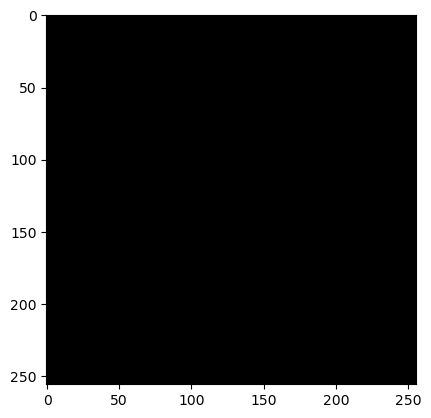

In [4]:
label = 1
train_test_split = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle')
gen_df = merge_collect_lists(ret, label)
gen_df = gen_df[gen_df['id'].isin(train_test_split['val'])]
gen_df = gen_df.sort_values(['id', 'slice']).reset_index()

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')

label_converter = LabelConverter(df_hcp, df_desired)
ds = MRIDataset_Imgs(gen_df, label_id=label, label_converter=label_converter, NUM_CLASSES=2)

def show_slice(ds, row_idx):
    #id = df.iloc[row_idx, 0]
    #sli = df.iloc[row_idx, 1]
    print(ds.get_slice_name(row_idx))

    img, seg = ds[row_idx]
    img, seg = img.numpy(), seg.numpy()
    img = np.transpose(img, (1,2,0)) / 255.0
    fig, ax = plt.subplots()    
    ax.imshow(img)
    show_mask(seg, ax, random_color=False)
    show_box((ds.data_frame.loc[row_idx, 'bbox_0'],
                ds.data_frame.loc[row_idx, 'bbox_1'],
                ds.data_frame.loc[row_idx, 'bbox_2'],
                ds.data_frame.loc[row_idx, 'bbox_3']
    ), ax, color='orange')

show_slice(ds, 0)

In [6]:
label_list = [1,5,58, 39, 100, 70, 82, 22, 71, 27, 68, 4]
train_test_split = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle')
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')

label_converter = LabelConverter(df_hcp, df_desired)



collector = {}
for label in label_list:
    print(f'On label {label}')
    gen_df = merge_collect_lists(ret, label)
    gen_df = gen_df[gen_df['id'].isin(train_test_split['val'])]
    gen_df = gen_df.sort_values(['id', 'slice']).reset_index()

    listo = []
    ds = MRIDataset_Imgs(gen_df, label_id=label, label_converter=label_converter, NUM_CLASSES=2)
    for r_idx in tqdm(range(gen_df.shape[0])):
        img, seg = ds[r_idx]
        img, seg = img.numpy(), seg.numpy()

        seg_area = (seg != 0).sum()
        listo.append(seg_area)
    
    gen_df['area'] = listo

    subdf = gen_df
    masker = pd.isna(subdf['confidence'])
    subdf.loc[masker, 'confidence'] = 0 # for curve plotting
    collector[label] = subdf



On label 1


100%|██████████| 28416/28416 [15:50<00:00, 29.91it/s]


On label 5


100%|██████████| 28416/28416 [16:24<00:00, 28.85it/s]


On label 58


100%|██████████| 28416/28416 [19:00<00:00, 24.92it/s]


On label 39


100%|██████████| 28416/28416 [16:47<00:00, 28.20it/s] 


On label 100


100%|██████████| 28416/28416 [15:57<00:00, 29.66it/s]


On label 70


100%|██████████| 28416/28416 [16:05<00:00, 29.43it/s] 


On label 82


100%|██████████| 28416/28416 [15:48<00:00, 29.96it/s]


On label 22


100%|██████████| 28416/28416 [16:26<00:00, 28.79it/s]


On label 71


100%|██████████| 28416/28416 [15:47<00:00, 30.00it/s]


On label 27


100%|██████████| 28416/28416 [15:51<00:00, 29.87it/s]


On label 68


100%|██████████| 28416/28416 [16:10<00:00, 29.29it/s]


On label 4


100%|██████████| 28416/28416 [16:02<00:00, 29.53it/s]  


In [5]:
listo = []
for r_idx in tqdm(range(gen_df.shape[0])):
    img, seg = ds[r_idx]
    img, seg = img.numpy(), seg.numpy()

    seg_area = (seg != 0).sum()
    listo.append(seg_area)

gen_df['area'] = listo

100%|██████████| 28416/28416 [15:50<00:00, 29.90it/s]


Text(0.5, 1.0, 'Label 1')

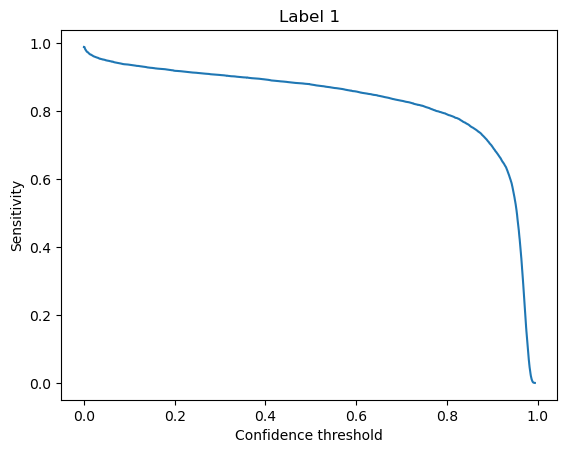

In [21]:


# for all areas > 0, how many have a bounding box that is nan? = false negative
# for all areas = 0, how many have a bounding box that IS NOT nan? = false positive

#conf = pred_y
#area>0 = actual_y
subdf = gen_df
masker = pd.isna(subdf['confidence'])
subdf.loc[masker, 'confidence'] = 0
precision, recall, thresholds = precision_recall_curve(subdf['area']>0, subdf['confidence'])
plt.plot(thresholds, recall[1:])
plt.ylabel('Sensitivity')
plt.xlabel('Confidence threshold')
plt.title('Label 1')

Text(0.5, 0, 'False Positive Rate')

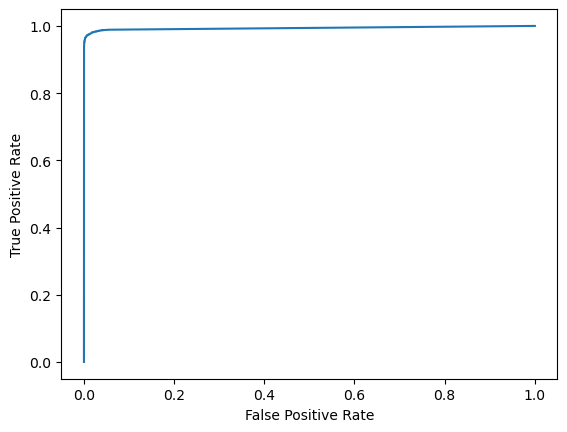

In [31]:
fpr, tpr, threshold = roc_curve(subdf['area']>0, subdf['confidence'])
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

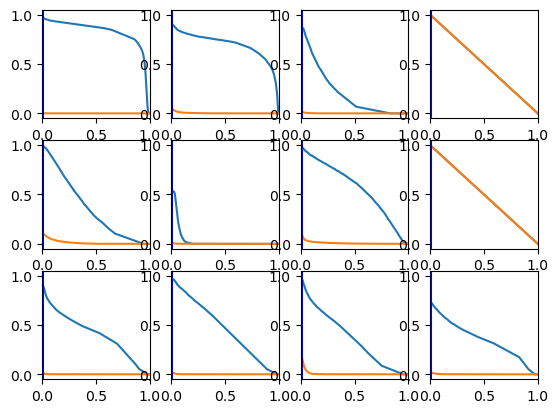

In [25]:

label_list = [1,5,58, 39, 100, 70, 82, 22, 71, 27, 68, 4]

ptr=0
nr = 3
nc = 4
fig, axs = plt.subplots(nr, nc)
for label in label_list:
    subdf = collector[label]
    fpr, tpr, threshold = roc_curve(subdf['area']>0, subdf['confidence'])

    ir = ptr // nc
    ic = ptr % nc

    axs[ir, ic].plot(threshold, tpr)
    axs[ir, ic].plot(threshold, fpr)
    axs[ir,ic].set_xlim([0.0, 1])
    axs[ir,ic].axvline(x = 0.01, color = 'b')
    ptr+=1